# Max Cut

- https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm#step-1-map-classical-inputs-to-a-quantum-problem

In [1]:
import numpy as np

# Import Qiskit
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import qiskit.quantum_info as qi
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np

from optimal_angle import *
import matplotlib.pyplot as plt

from qiskit.circuit.library import QAOAAnsatz
import networkx as nx


;;; Loading "/usr/local/lib/sage/local/lib/ecl/maxima.fas"
;;; Loading #P"/usr/lib/x86_64-linux-gnu/ecl-21.2.1/sb-bsd-sockets.fas"
;;; Loading #P"/usr/lib/x86_64-linux-gnu/ecl-21.2.1/sockets.fas"


In [2]:
from qiskit.quantum_info import SparsePauliOp
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edges()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = 1.0 # graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis), weight))

    return pauli_list

In [34]:
n = 20
# graph = graphs.RandomRegular(3,n)
graph = nx.from_graph6_bytes(b'S{S__OC@?D?Q?Q?O?C??`?@??B??AW?@o') 

optimal_angles = optimal_angles_graph(graph)


max_cut_paulis = build_max_cut_paulis(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
# print("Cost Function Hamiltonian:", cost_hamiltonian)

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=1)
circuit.measure_all()

# circuit.draw('mpl')

good_params = [optimal_angles['b'], optimal_angles['c']]
# good_params = [random()*2*pi, random()*pi]
good_circuit = circuit.assign_parameters(good_params)

# Transpile for simulator
simulator = AerSimulator()
qc = transpile(good_circuit, simulator)

# Run and get counts
result = simulator.run(qc, shots=10000000).result()
counts = result.get_counts(qc)
#plot_histogram(counts, title='Resultados de Medida')

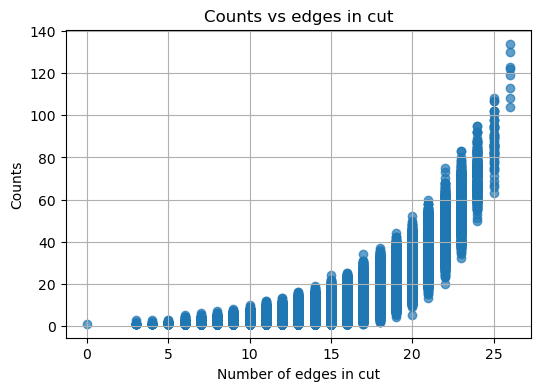

In [35]:
states = list(counts.keys())
states.sort( key = lambda x: counts[x])

def nr_edges_in_cut(cut):
    return len([ e for e in graph.edges() if cut[e[0]] != cut[e[1]]])

hits = [ (nr_edges_in_cut(x), counts[x]) for x in states]

edges = [h[0] for h in hits]
counts_list = [h[1] for h in hits]

# Scatter of individual states: number of edges in cut vs counts
plt.figure(figsize=(6,4))
plt.scatter(edges, counts_list, alpha=0.7)
plt.xlabel('Number of edges in cut')
plt.ylabel('Counts')
plt.title('Counts vs edges in cut')
plt.grid(True)
plt.show()

TypeError: Invalid Input Type <class 'networkx.classes.graph.Graph'> for graph

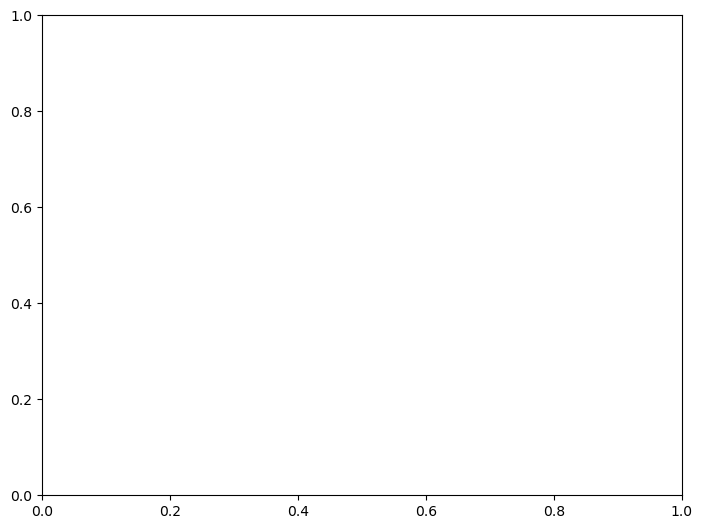

In [36]:
cut = states[0]
colors = ["tab:orange" if b == "1" else "tab:blue" for b in cut]

from rustworkx.visualization import mpl_draw as draw_graph
import matplotlib.pyplot as plt

ax = draw_graph(graph, node_size=600, with_labels=True, node_color=colors)
plt.title(f"Coloring by bitstring {cut} (1=orange, 0=blue)")
plt.show()

In [ ]:
import networkx as nx
import cvxpy as cp
import numpy as np

def goemans_williamson_max_cut(graph):
    n = graph.number_of_nodes()
    
    # Define variables for the SDP
    X = cp.Variable((n, n), symmetric=True)
    
    # Define objective function
    obj = cp.Maximize(cp.sum([0.25 * (1 - X[i, j]) for i, j in graph.edges()]))
    
    # Define constraints
    constraints = [X >> 0] # X must be positive semi-definite
    constraints += [X[i, i] == 1 for i in range(n)] # Diagonal elements are 1
    
    # Solve the SDP
    problem = cp.Problem(obj, constraints)
    problem.solve(solver='SCS') # SCS is a suitable solver
    
    # Retrieve the solution
    X_val = X.value
    
    # Random hyperplane rounding
    best_cut_value = 0
    best_partition = None
    
    for _ in range(100): # Repeat rounding multiple times
        r = np.random.randn(n)
        partition = [1 if np.dot(r, X_val[i, :]) >= 0 else -1 for i in range(n)]
        
        current_cut_value = 0
        for u, v in graph.edges():
            if partition[u] != partition[v]:
                current_cut_value += 1
        
        if current_cut_value > best_cut_value:
            best_cut_value = current_cut_value
            best_partition = partition
            
    return best_cut_value, best_partition



Max Cut Value: 3
Partition: [1, 1, -1, 1]


In [37]:
# Example usage:
max_cut_value, partition = goemans_williamson_max_cut(graph)
print(f"Max Cut Value: {max_cut_value}")
print(f"Partition: {partition}")

Max Cut Value: 26
Partition: [1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, 1, -1, 1, -1, -1, -1]
